# Baseline CNN model - High level Architecture

In [44]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Baseline CNN model - High level Architecture

## Functions
- `tokenise_image()`: Splits an image into at most 8 distinct subimages of 80x80 pixels. This is done by checking column by column and cutting the image at all-white columns after non-white columns (character ends). Check if the number of subimages is equal to the number of label characters, else throw them out.
- `build_dataset()`: Builds a character-by-character training set from the images. 
- `build_cnn_model()`: Builds the baseline CNN model, output is a single one-hot classification vector of 36 possible categorical values (`a-z0-9`). 
- `predict_image()`: takes an image, tokenises it, runs each subimage into the CNN model, comes out with <=8 outputs and labels, compare with the original label.

In [45]:
# Assumes image has already been imported as a grayscale OpenCV image
def tokenise_image(img):
  min_width = 3

  # sum columns of image
  col_sum = np.sum(img, axis=0)

  # detect character start and end indices
  splits = []
  in_char = False
  start = 0
  for i, val in enumerate(col_sum):
    if not in_char and val < 20400:  # start of character
      in_char = True
      start = i
    elif in_char and val == 20400:  # end of character
      in_char = False
      end = i
      if end - start > min_width:
        splits.append((start, end))

  # handle edge case: last char till end
  if in_char:
    splits.append((start, len(col_sum)))

  # crop each detected region
  chars = []
  for (start, end) in splits:
    # this is the trimmed image. guaranteed to have a height of 80.
    char_img = img[:, start:end]
    
    # pad to make square (80x80)
    h, w = char_img.shape
    padded = np.ones((80, 80), dtype=np.uint8) * 255
    scale = 76 / max(h, w)
    resized = cv2.resize(char_img, (int(w * scale), int(h * scale)))
    ph, pw = resized.shape
    padded[(80 - ph)//2:(80 - ph)//2 + ph, (80 - pw)//2:(80 - pw)//2 + pw] = resized
    chars.append(padded)
    
  return chars

def show_tokenised(chars):
    plt.figure(figsize=(len(chars)*2, 2))  # adjust width dynamically
    for i, c in enumerate(chars):
        plt.subplot(1, len(chars), i + 1)
        plt.imshow(c, cmap='gray')
        plt.axis('off')
    plt.show()

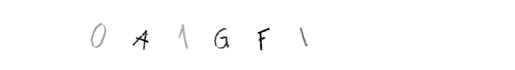

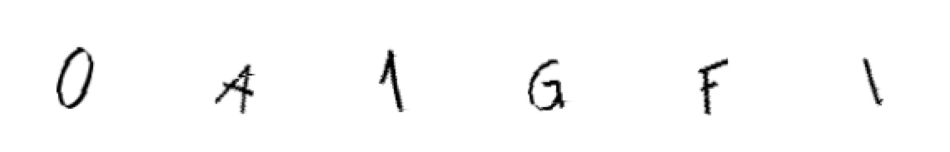

In [46]:
# Example of tokenising an image
image_name = "0a1gfi"
test_image = cv2.imread(f"./train/{image_name}-0.png", cv2.IMREAD_GRAYSCALE)
tokenised_images = tokenise_image(test_image)
plt.imshow(test_image, cmap='gray')
plt.axis('off')   # hide axes
plt.show()

show_tokenised(tokenised_images)

In [47]:
# Helper functions to assign each letter and digit to label numbers

CHARSET = "abcdefghijklmnopqrstuvwxyz0123456789"

char_to_idx = {ch: idx for idx, ch in enumerate(CHARSET)}
idx_to_char = {idx: ch for idx, ch in enumerate(CHARSET)}

# encodes character to the 36-character set
def encode(character):
  return char_to_idx[character]

def decode(character):
  return idx_to_char[character]

encode_array = np.vectorize(encode)
decode_array = np.vectorize(decode)

print(encode("a"), encode("z"), encode("0"), encode("9"))
print(encode("y")) # 24
print(encode("6")) # 32
print(decode(17)) # r
print(decode(34)) # 8
print(encode_array(np.array(["a", "z", "0", "9"])))
print(decode_array(np.array([0, 25, 26, 35])))

0 25 26 35
24
32
r
8
[ 0 25 26 35]
['a' 'z' '0' '9']


In [48]:
def build_training_dataset(train_dir = "./train"):
  image_files = [f for f in os.listdir(train_dir) if f.lower().endswith((".png"))]

  X = []
  y = []
  lengths = []

  for fname in image_files:
    # Split at '-' to isolate the captcha text
    label = fname.split('-')[0]

    image = cv2.imread(f"{train_dir}/{fname}", cv2.IMREAD_GRAYSCALE)

    tokenised_images = tokenise_image(image)
    if len(label) == len(tokenised_images):
      for i in range(len(label)):
        X.append(tokenised_images[i])
        y.append(label[i])
      lengths.append(len(label))

  X = np.array(X)
  X = X[..., np.newaxis]
  X = X.astype("float32") / 255.0
  y = np.array(y)

  y_encoded = encode_array(y)

  y_onehot = to_categorical(y_encoded, num_classes=36)

  return X, y_onehot, lengths

X_train, y_train, lengths_train = build_training_dataset()
X_test, y_test, lengths_test = build_training_dataset("./test")
print(X_train.shape, y_train.shape, len(lengths_train))
print(X_test.shape, y_test.shape, len(lengths_test))

(32797, 80, 80, 1) (32797, 36) 5526
(10083, 80, 80, 1) (10083, 36) 1694


In [49]:
def build_cnn_model(input_shape=(80, 80, 1)):
    inputs = Input(shape = input_shape)

    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    # x = Conv2D(256, 3, activation='relu', padding='same')(x)
    # x = MaxPooling2D(2)(x)

    # resulting shape: (10, 10, 128)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(36, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [50]:
# build CAPTCHA CNN
model = build_cnn_model()

callbacks=[
  EarlyStopping(monitor='val_accuracy', patience=12, mode='max', restore_best_weights=True),
  ReduceLROnPlateau(factor=0.5, patience=5)
]

# train model on training data
history = model.fit(
  X_train,
  y_train,
  validation_data=(X_test, y_test),
  epochs=80,
  batch_size=32,
  callbacks=callbacks
)

# save model
model.save("captcha_cnn_model.keras")

Epoch 1/80
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.2396 - loss: 2.7069 - val_accuracy: 0.5470 - val_loss: 1.5730 - learning_rate: 0.0010
Epoch 2/80
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.5440 - loss: 1.5018 - val_accuracy: 0.6510 - val_loss: 1.1926 - learning_rate: 0.0010
Epoch 3/80
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6335 - loss: 1.1910 - val_accuracy: 0.7080 - val_loss: 0.9758 - learning_rate: 0.0010
Epoch 4/80
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6777 - loss: 1.0267 - val_accuracy: 0.7356 - val_loss: 0.8994 - learning_rate: 0.0010
Epoch 5/80
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7087 - loss: 0.9240 - val_accuracy: 0.7514 - val_loss: 0.8254 - learning_rate: 0.0010
Epoch 6/80
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7319 - loss: 0.8383 - val_accuracy: 0.7628 - val_loss: 0.8169 - learning_rate: 0.0010
Epoch 7/80
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accura

# Observations from model

## Learning Curves

Learning curves to track the progress of training and validation accuracy/loss over epochs.

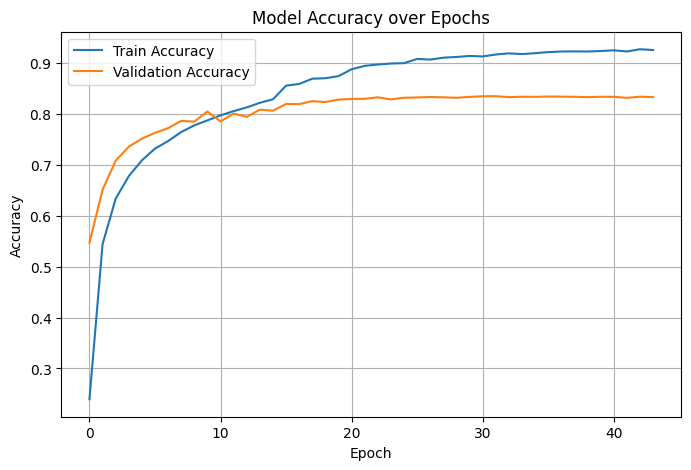

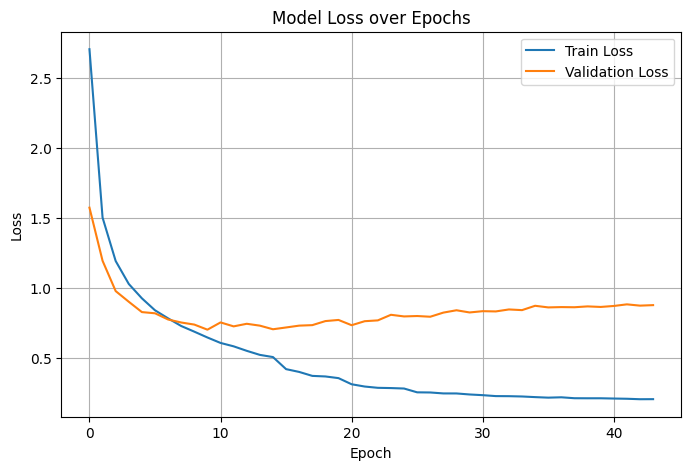

In [54]:
import matplotlib.pyplot as plt

# Accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Recognition Scores

Reports both character and CAPTCHA accuracy.


In [55]:
# calculate accuracy
y_pred = model.predict(X_test)
decoded_pred = decode_array(np.argmax(y_pred, axis=1))
decoded_true = decode_array(np.argmax(y_test, axis=1))

pred_strings, true_strings = [], []
i = 0
for length in lengths_test:
  pred_strings.append(''.join(decoded_pred[i:i+length]))
  true_strings.append(''.join(decoded_true[i:i+length]))
  i += length

correct = sum(p == t for p, t in zip(pred_strings, true_strings))
captcha_acc = correct / len(lengths_test)

print(f"Captcha-level accuracy: {(captcha_acc*100):.4f}%")

char_acc = np.mean(decoded_pred == decoded_true)
print(f"Character-level accuracy: {(char_acc*100):.4f}%")


316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Captcha-level accuracy: 47.9929%
Character-level accuracy: 83.4771%


## Confusion matrix

Confusion matrix to show common misclassifications made by the model between predicted and true CAPTCHA data.

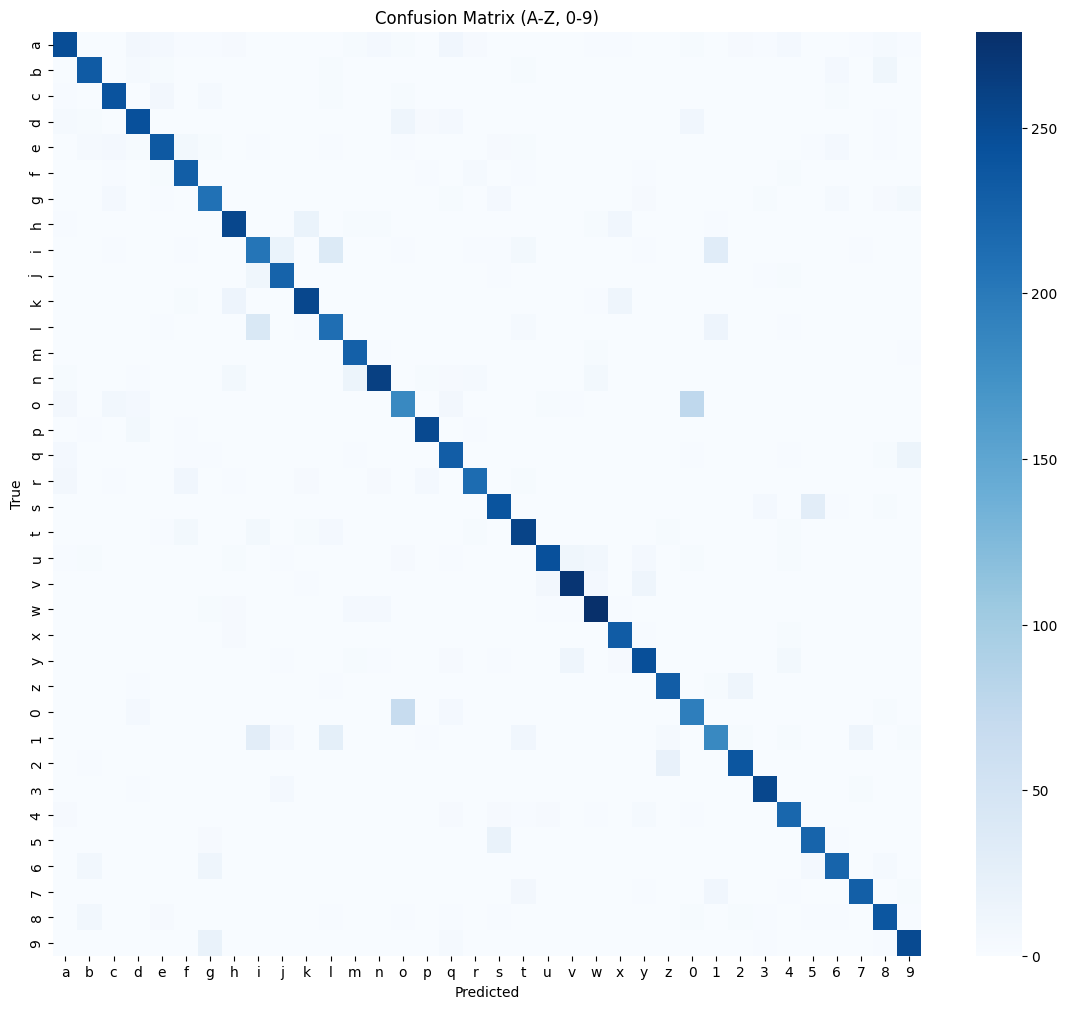

In [56]:
# Confusion matrix for one-hot class indices
cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=CHARSET, yticklabels=CHARSET)
plt.title('Confusion Matrix (A-Z, 0-9)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

